# Simulating lattice gauge theory with `ymcirc`

This notebook provides an overview of how to generate LGT simulation circuits with `ymcirc`, how to execute them, and how to analyze the resulting job data.

## Requirements

- Python 3.10.
- Qiskit SDK 1.2 or higher (tested up to 2.1.2) and Qiskit Aer 0.17.1.
- The `ymcirc` package also needs to be present in the same directory as this notebook file.

## Setup

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import sys
 
from ymcirc._abstract import LatticeDef
from ymcirc.circuit import LatticeCircuitManager
from ymcirc.conventions import (
    IRREP_TRUNCATIONS, ONE, THREE, THREE_BAR, SIX, SIX_BAR, EIGHT,
    LatticeStateEncoder, load_magnetic_hamiltonian, PHYSICAL_PLAQUETTE_STATES,
)
from ymcirc.electric_helper import convert_bitstring_to_evalue, electric_hamiltonian
from ymcirc.lattice_registers import LatticeRegisters
from ymcirc.parsed_lattice_result import ParsedLatticeResult
 
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

`ymcirc` has a built-in logger which can be useful for debugging or obtaining estimates of remaining circuit construction time. Set the logging level to `INFO` or `DEBUG` if desired. If this logging is too noisy, set the logging level to `WARNING` or comment this code block out:

In [2]:
level = logging.INFO  # Default is logging.WARNING
logger = logging.getLogger("ymcirc")
logging.getLogger('ymcirc').setLevel(level)
handler = logging.StreamHandler(sys.stdout)
handler.setFormatter(logging.Formatter('%(name)s:%(levelname)s:%(message)s'))
logger.addHandler(handler)

## Step 1: Collect data about the lattice we want to simulate

There are a LOT of options a user might want to specify. Here's a reasonably comprehensive set of them.

In [3]:
# Irrep info and physical paramters.
dim_string = "d=2" # options: "d=3/2", "d=2"
trunc_string = "T1" # options: "T1", "T2"
link_bitmap = IRREP_TRUNCATIONS[trunc_string]
coupling_g = 1.0

# Circuit optimizations.
prune_controls = True
control_fusion = True
electric_gray_order = True
use_ancillas = True
use_qiskit_circuit_optimization = False

# Approximations.
mag_hamiltonian_matrix_element_threshold = 0.5
only_include_elems_connected_to_electric_vacuum = False

# Simulation type
sim_duration = 2.5
n_trotter_steps = 2
do_magnetic_evolution = True
do_electric_evolution = True
n_shots = 10000
simulator_backend = 'matrix_product_state' # see Qiskit AerSimulator documentation for more options

# Define the lattice geometry.
numerical_dimensions = 1.5 if (dim_string == "d=3/2" or dim_string == "d=1.5") else int(dim_string[2:])
lattice = LatticeDef(
    dimensions=numerical_dimensions,
    size=2,  # Controls the number of plaquettes.
    periodic_boundary_conds=True
)
print(f"Created lattice:\n{lattice}")

Created lattice:
d=2, 4 plaquettes, shape=(2, 2), periodic boundary conditions


Note that the time required to construct `size=3` circuits can be significantly longer than `size=2` because there are symmetries on a periodic lattice which reduce the number of physical plaquette states for `size=2`. This corresponds to the magnetic Hamiltonian matrix element data being larger for `size=3` or higher, which in turn corresponds to additional Givens rotations not present for `size=2`.

## Step 2: Generate a simulation circuit

Having defined the parameters of our simulation, we can now construct a simulation circuit. First, we set up a `LatticeStateEncoder` which is used internally for handling how to map physical lattice data to or from bitstrings. We can then use this encoder to load our magnetic Hamiltonian data, and define the set of bit strings corresponding to physical plaquettes (this is one of the inputs to the control pruning algorithm).

In [4]:
# For handling maps between bitstrings and physical state data.
lattice_encoder = LatticeStateEncoder(
    link_bitmap=link_bitmap,
    physical_plaquette_states=PHYSICAL_PLAQUETTE_STATES[dim_string][trunc_string],
    lattice=lattice
)

# Load in the magnetic Hamiltonian for the desired lattice.
mag_hamiltonian = load_magnetic_hamiltonian(
    dim_string=dim_string,
    trunc_string=trunc_string,
    lattice_encoder=lattice_encoder,
    mag_hamiltonian_matrix_element_threshold=mag_hamiltonian_matrix_element_threshold,
    only_include_elems_connected_to_electric_vacuum=only_include_elems_connected_to_electric_vacuum
)

# Load in the electric Hamiltonian given the link irreps.
e_hamiltonian = electric_hamiltonian(lattice_encoder.link_bitmap)

# Get physical plaquette state data if necessary (an input for control pruning)
if prune_controls is True:
    physical_plaquette_states = set(lattice_encoder.encode_plaquette_state_as_bit_string(plaquette) for plaquette in PHYSICAL_PLAQUETTE_STATES[dim_string][trunc_string])
else:
    physical_plaquette_states = None

print(f"Created:\n{lattice_encoder}")

ymcirc.conventions:INFO:Created Lattice encoder:
link bitmap = {(0, 0, 0): '00', (1, 0, 0): '10', (1, 1, 0): '01'}
vertex bitmap = {0: '0', 1: '1'}
lattice geometry = d=2, 4 plaquettes, shape=(2, 2), periodic boundary conditions.
ymcirc.conventions:INFO:Loaded pre-computed magnetic Hamiltonian data from disk for d=2, T1. There are 483 Givens rotations per plaquette.
Created:
Lattice encoder:
link bitmap = {(0, 0, 0): '00', (1, 0, 0): '10', (1, 1, 0): '01'}
vertex bitmap = {0: '0', 1: '1'}
lattice geometry = d=2, 4 plaquettes, shape=(2, 2), periodic boundary conditions


Next, we configure a `LatticeRegisters` instance which allows for indexing `qiskit`'s `QuantumRegister` instances via lattice coordinates. We then use a `LatticeCircuitManager` to build a simulation circuit with one or more Trotter steps.

In [5]:
# Create blank simulation circuit.
lattice_registers = LatticeRegisters.from_lattice_state_encoder(lattice_encoder)
circ_mgr = LatticeCircuitManager(lattice_encoder, mag_hamiltonian)
circ = circ_mgr.create_blank_full_lattice_circuit(lattice_registers)

# Optionally add ancilla register if using v-chain construction for MCX gates.
if use_ancillas is True:
    circ_mgr.num_ancillas = circ_mgr.compute_num_ancillas_needed_from_mag_trotter_step(
        circ,
        lattice_registers,
        control_fusion=control_fusion,
        physical_states_for_control_pruning=physical_plaquette_states,
        optimize_circuits=use_qiskit_circuit_optimization
    )
    circ_mgr.add_ancilla_register_to_quantum_circuit(circ)

print(f"Created:\n{lattice_registers}\n")
print(f"Created:\n{circ_mgr}\n")

# Append parameterized time evolution to circuit.      
for _ in range(n_trotter_steps):
    if do_magnetic_evolution is True:
        circ_mgr.apply_magnetic_trotter_step(
            circ,
            lattice_registers,
            optimize_circuits=use_qiskit_circuit_optimization,
            physical_states_for_control_pruning=physical_plaquette_states,
            control_fusion=control_fusion,
            cache_mag_evol_circuit=True  # Makes circuit generation faster.
        )
    if do_electric_evolution is True:
        circ_mgr.apply_electric_trotter_step(
            circ,
            lattice_registers,
            hamiltonian=e_hamiltonian,
            electric_gray_order=electric_gray_order
        )

# Append final measurement step
circ.measure_all()

ymcirc.lattice_registers:INFO:Created Quantum registers indexable on a lattice with the geometry: d=2, 4 plaquettes, shape=(2, 2), periodic boundary conditions. Lattice has 20 qubits, 4 plaquettes, 8 links, and 4 vertices.
ymcirc.circuit:INFO:Computing but not caching a magnetic Trotter step to determine num ancillas needed.
ymcirc.circuit:INFO:There are 705 plaquette states.
ymcirc.circuit:INFO:Building magnetic evolution circuit from scratch.
ymcirc.circuit:INFO:There are 19 primitive Givens rotation circuits to be constructed for the plaquette.
ymcirc.circuit:INFO:Constructing rotation circuit for LP bin 1/19 with 1 Givens rotations.
ymcirc.circuit:INFO:More iterations needed to estimate time remaining.
ymcirc.circuit:INFO:Constructing rotation circuit for LP bin 2/19 with 1 Givens rotations.
ymcirc.circuit:INFO:Estimated time remaining: 0s
ymcirc.circuit:INFO:Constructing rotation circuit for LP bin 3/19 with 1 Givens rotations.
ymcirc.circuit:INFO:Estimated time remaining: 0s
ymci

We now have a simulation circuit. We can draw it:

In [6]:
# If the circuit is too large, the circuit drawer can fail.
try:
    circ.draw(output='mpl')
except ValueError as e:
    print(f"Failed to render circuit: {e}")

We can also extract gate counts from it:

In [7]:
circ.count_ops()

OrderedDict([('cx', 13808),
             ('t', 8192),
             ('tdg', 7888),
             ('h', 7584),
             ('u', 2912),
             ('rz', 352),
             ('ry', 304),
             ('measure', 27),
             ('barrier', 1)])

## Step 3: Execute using Qiskit primitives

We can use Aer to run a simulation of the circuit. Before doing this, we use `sim_duration` and `couling_g` to assign all circuit parameters, and then transpile for the particular backend in use. See the [Aer documentation](https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.AerSimulator.html) for a list of available backends.

In [8]:
# Create simulation backend, assign circuit parameters, and transpile circuit for backend.
sim_backend = AerSimulator(method=simulator_backend)
dt = sim_duration / n_trotter_steps
parameter_values = {}
for param in circ.parameters:
    print(f"Assigning parameter: {param}")
    if 'dt' in param.name:
        parameter_values[param.name] = dt
    elif 'coupling_g' in param.name:
        parameter_values[param.name] = coupling_g
circ.assign_parameters(parameter_values, inplace=True)
circ = transpile(circ, sim_backend, optimization_level=3)

# Run simulation.
job = sim_backend.run(circ, shots=n_shots)
job_counts = job.result().get_counts(0)

Assigning parameter: coupling_g_ee__0
Assigning parameter: coupling_g_ee__1
Assigning parameter: coupling_g_mag__0
Assigning parameter: coupling_g_mag__1
Assigning parameter: dt_ee__0
Assigning parameter: dt_ee__1
Assigning parameter: dt_mag__0
Assigning parameter: dt_mag__1


## Step 4: Post-processing and analysis

Bit strings in qiskit are little-endian, so we need to flip all the measurement bit strings around before we try to parse them.

In [9]:
# Convert results to big-endian convention.
n_data_qubits = len(circ.qubits) - len(circ.ancillas)
counts_big_endian = {little_endian_state[::-1][:n_data_qubits]: count for little_endian_state, count in job_counts.items()}

Now let's map these degrees of freedom onto physically meaningful data.

In [10]:
iweight_to_irrep_str = {
    ONE: "1",
    THREE: "3",
    THREE_BAR: "~3",
    SIX: "6",
    SIX_BAR: "~6",
    EIGHT: "8"
}
counts_irrep_str = {}

# We parse each bitstring to a lattice, then obtain the irrep data.
for state in counts_big_endian.keys():
    state_as_irrep_str = ""
    parsed_state = ParsedLatticeResult(
        dimensions=numerical_dimensions,
        size=lattice.shape[0], global_lattice_measurement_bit_string=state,
        lattice_encoder=lattice_encoder,
        periodic_boundary_conds=lattice.periodic_boundary_conds)
    print(parsed_state.get_traversal_order())
    for vertex_address, attached_links in parsed_state.get_traversal_order():
        for link_address in attached_links:
            link_irrep_str = iweight_to_irrep_str[parsed_state.get_link(link_address)]
            state_as_irrep_str += link_irrep_str
    print(f"{state} decodes to {state_as_irrep_str}")
    counts_irrep_str[state_as_irrep_str] = counts_big_endian[state]

[((0, 0), [((0, 0), 1), ((0, 0), 2)]), ((0, 1), [((0, 1), 1), ((0, 1), 2)]), ((1, 0), [((1, 0), 1), ((1, 0), 2)]), ((1, 1), [((1, 1), 1), ((1, 1), 2)])]
00000000010100000110 decodes to 111~331~33
[((0, 0), [((0, 0), 1), ((0, 0), 2)]), ((0, 1), [((0, 1), 1), ((0, 1), 2)]), ((1, 0), [((1, 0), 1), ((1, 0), 2)]), ((1, 1), [((1, 1), 1), ((1, 1), 2)])]
00110010000000100000 decodes to ~33311~311
[((0, 0), [((0, 0), 1), ((0, 0), 2)]), ((0, 1), [((0, 1), 1), ((0, 1), 2)]), ((1, 0), [((1, 0), 1), ((1, 0), 2)]), ((1, 1), [((1, 1), 1), ((1, 1), 2)])]
00100010010000000010 decodes to ~313~31113
[((0, 0), [((0, 0), 1), ((0, 0), 2)]), ((0, 1), [((0, 1), 1), ((0, 1), 2)]), ((1, 0), [((1, 0), 1), ((1, 0), 2)]), ((1, 1), [((1, 1), 1), ((1, 1), 2)])]
01000001100000000001 decodes to 31~33111~3
[((0, 0), [((0, 0), 1), ((0, 0), 2)]), ((0, 1), [((0, 1), 1), ((0, 1), 2)]), ((1, 0), [((1, 0), 1), ((1, 0), 2)]), ((1, 1), [((1, 1), 1), ((1, 1), 2)])]
00001000000011001000 decodes to 1~311~3331
[((0, 0), [((0, 0), 

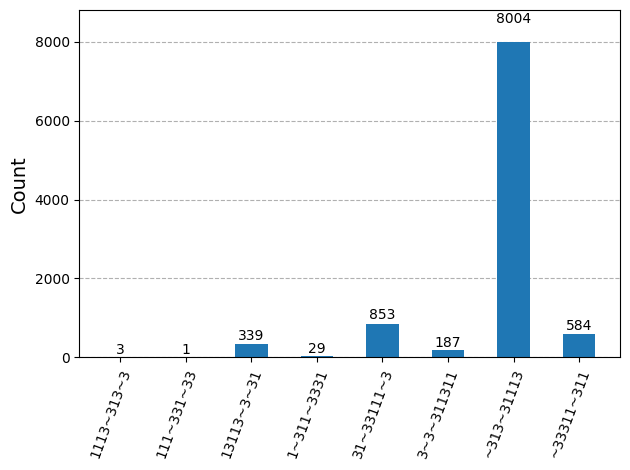

In [11]:
plot_histogram(counts_irrep_str)

We can also do something like the following to get a more physical picture of the lattice states appearing in the counts data.

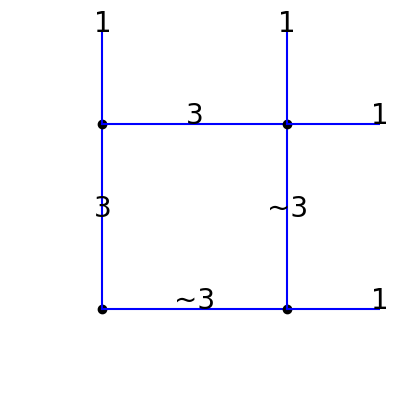

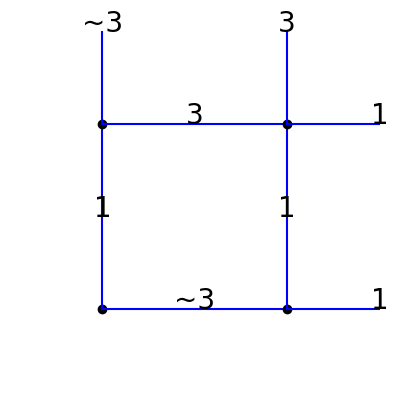

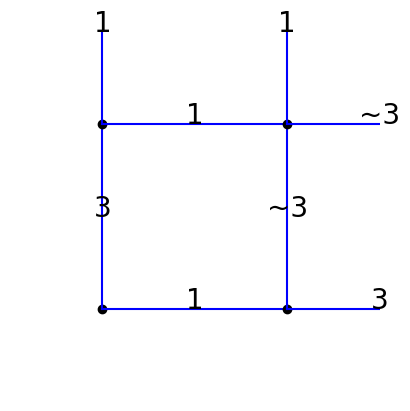

In [12]:
def draw_lattice_state(state: ParsedLatticeResult, iweight_to_irrep_str_map: dict) -> plt.Figure:
    lattice_layout = state.get_traversal_order()
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Iterate through the input data
    for point, links in lattice_layout:
        x, y = point
        ax.plot(x, y, 'ko')  # Plot the lattice point
        
        # Iterate through the links
        for link in links:
            link_point, direction = link
            assert direction in {1, 2}
            x_link, y_link = link_point
            if direction == 1:
                x_link += 1
            elif direction == 2:
                y_link += 1
            
            # Draw the link
            ax.plot([x, x_link], [y, y_link], 'b-')  # Draw the link
            
            # Label the link
            irrep_label = iweight_to_irrep_str_map[state.get_link(link)]
            ax.text((x + x_link) / 2, (y + y_link) / 2, f'{irrep_label}', fontsize=20, ha='center')

    # Set limits and aspect
    ax.set_xlim(-0.5, max(x for point, _ in lattice_layout for x, _ in [point]) + 0.5)
    ax.set_ylim(-0.5, max(y for point, _ in lattice_layout for _, y in [point]) + 0.5)
    ax.set_aspect('equal')
    
    # Hide axes
    ax.axis('off')
    
    return fig

for state in counts_big_endian.keys():
    state_as_irrep_str = ""
    parsed_state = ParsedLatticeResult(
        dimensions=numerical_dimensions,
        size=lattice.shape[0], global_lattice_measurement_bit_string=state,
        lattice_encoder=lattice_encoder,
        periodic_boundary_conds=lattice.periodic_boundary_conds)
    draw_lattice_state(parsed_state, iweight_to_irrep_str)